In [24]:
import sys
import os
import pandas as pd
import numpy as np
from sklearn import preprocessing
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import tqdm
from sklearn.preprocessing import LabelEncoder

import missingno

src_path = os.path.dirname(os.getcwd())
sys.path.append(src_path)
        
from src.trainer.classifiers import train_classifier_lazy, run_model
from src.trainer.metrics import get_max_metrics
from src.dataloader.preprocessing import get_date, time_feature_engineering, labelencode, num_to_cat, get_total_occurrence, feature_to_bin
from src.utils.plotting import plot_features_importances

In [25]:
data = pd.read_csv('../data/medical_appointment.csv')
# drop useless feature
to_drop = ['AppointmentID']
data = data.drop(to_drop, axis=1)

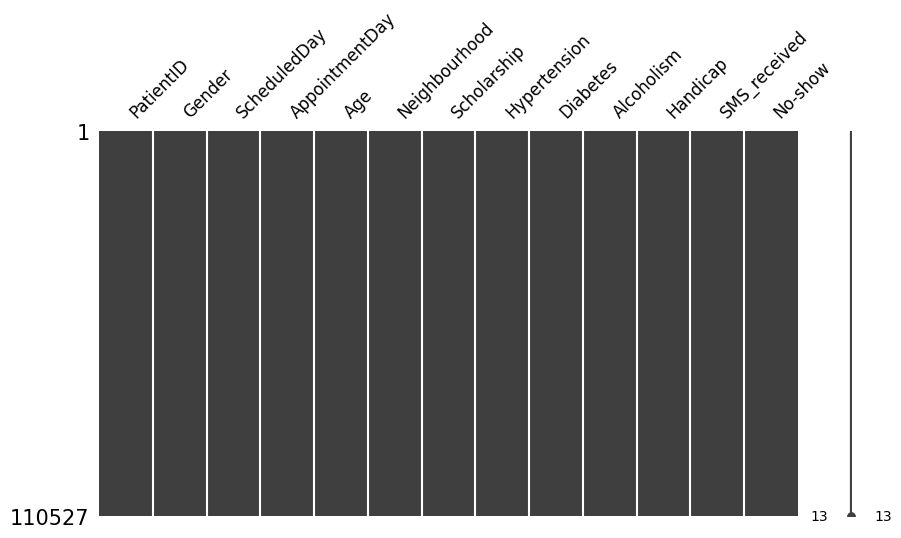

In [26]:
missingno.matrix(data,figsize=(10,5), fontsize=12);
plt.show()

In [27]:
data.tail(5)

,PatientID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,No-show
110522,2572134369293.00,F,2016-05-03T09:15:35Z,2016-06-07T00:00:00Z,56,MARIA ORTIZ,0,0,0,0,0,1,No
110523,3596266328735.00,F,2016-05-03T07:27:33Z,2016-06-07T00:00:00Z,51,MARIA ORTIZ,0,0,0,0,0,1,No
110524,15576631729893.00,F,2016-04-27T16:03:52Z,2016-06-07T00:00:00Z,21,MARIA ORTIZ,0,0,0,0,0,1,No
110525,92134931435557.00,F,2016-04-27T15:09:23Z,2016-06-07T00:00:00Z,38,MARIA ORTIZ,0,0,0,0,0,1,No
110526,377511518121127.00,F,2016-04-27T13:30:56Z,2016-06-07T00:00:00Z,54,MARIA ORTIZ,0,0,0,0,0,1,No


### Some EDA

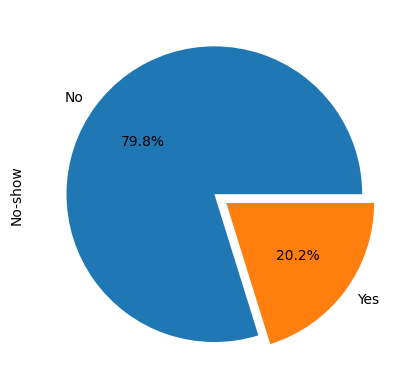

In [28]:
data['No-show'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%')
plt.show()

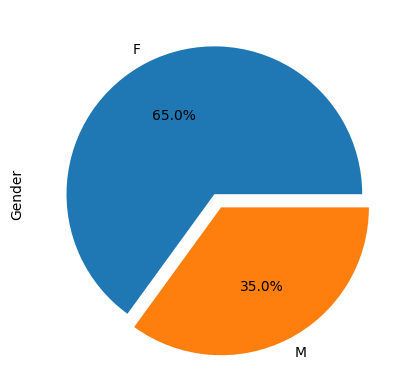

In [29]:
data['Gender'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%')
plt.show()

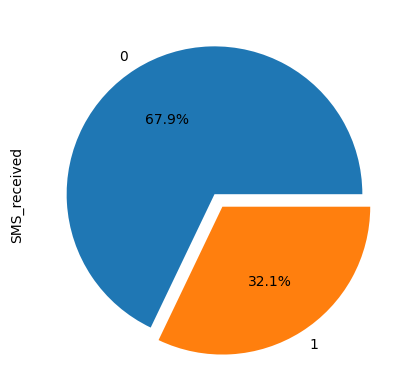

In [30]:
data['SMS_received'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%')
plt.show()

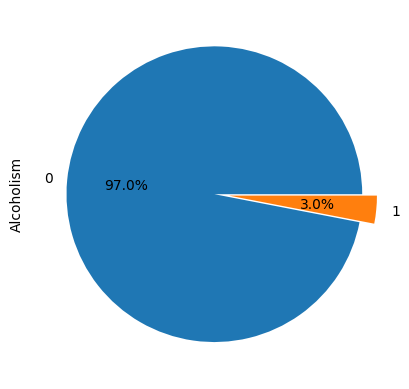

In [31]:
data['Alcoholism'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%')
plt.show()

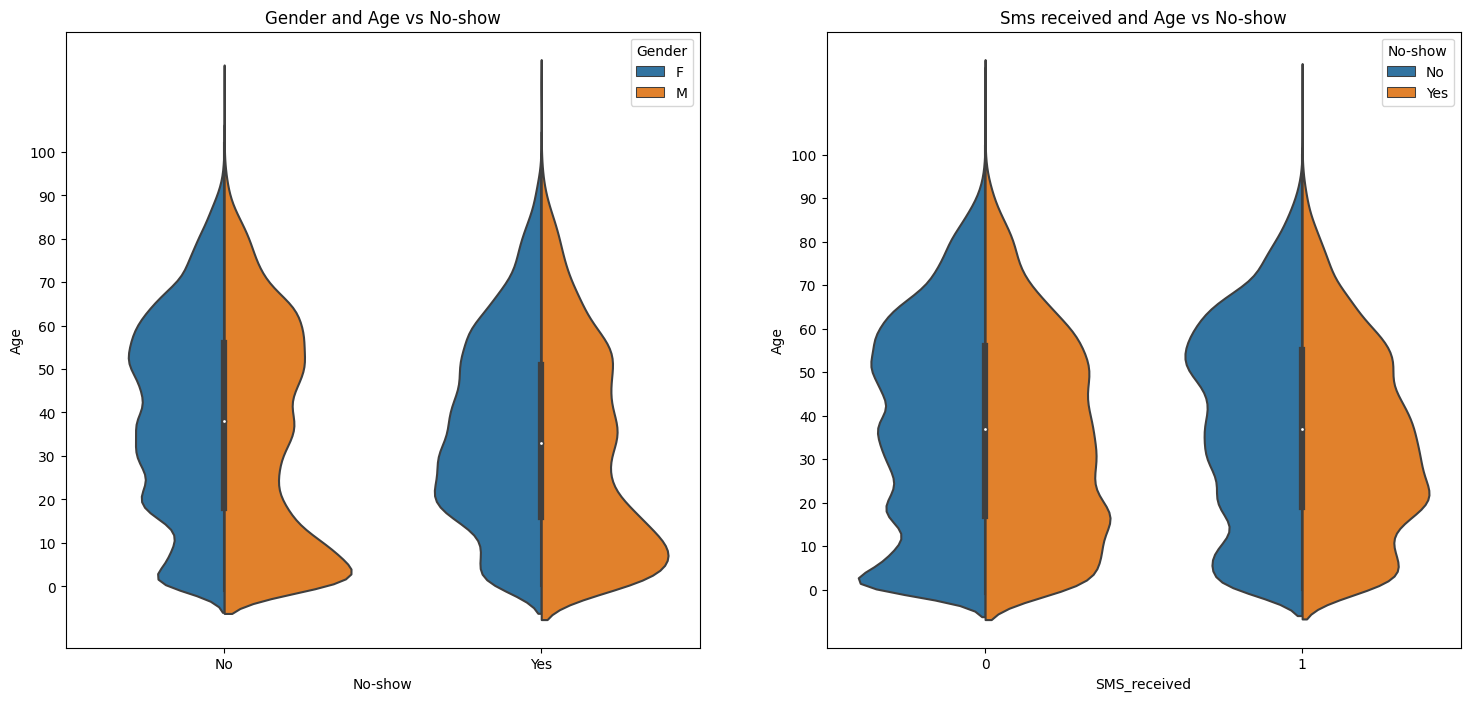

In [32]:
f,ax=plt.subplots(1,2,figsize=(18,8))
sns.violinplot("No-show","Age", hue="Gender", data=data,split=True,ax=ax[0])
ax[0].set_title('Gender and Age vs No-show')
ax[0].set_yticks(range(0,110,10))
sns.violinplot("SMS_received","Age", hue="No-show", data=data,split=True,ax=ax[1])
ax[1].set_title('Sms received and Age vs No-show')
ax[1].set_yticks(range(0,110,10))
plt.show()

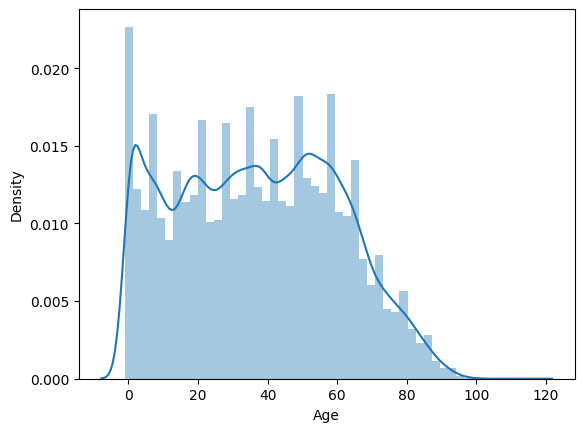

In [33]:
sns.distplot(data['Age'])
plt.show()


## Feature engineering

In [34]:
# time feature engineering
data = time_feature_engineering(data)

In [35]:
# get frequency category
data = get_total_occurrence(data, feature='PatientID', max_frequency=3)

In [36]:
# bin age
data = feature_to_bin(data, feature_name='Age', bins=[data['Age'].min(), 20, 40, 55, 75, data['Age'].max()])

In [37]:
data.Age_bins.value_counts()

0.00    31848
1.00    28835
2.00    22339
3.00    22112
4.00     5392
Name: Age_bins, dtype: int64

In [38]:
data.dtypes

Gender                      object
Age                          int64
Neighbourhood               object
Scholarship                  int64
Hypertension                 int64
Diabetes                     int64
Alcoholism                   int64
Handicap                     int64
SMS_received                 int64
No-show                     object
Month_sch                    int64
Day_sch                      int64
Hour_sch                     int64
Minute_sch                   int64
Second_sch                   int64
Month_apt                    int64
Day_apt                      int64
Nb_occurrence_PatientID      int64
Age_bins                   float64
dtype: object

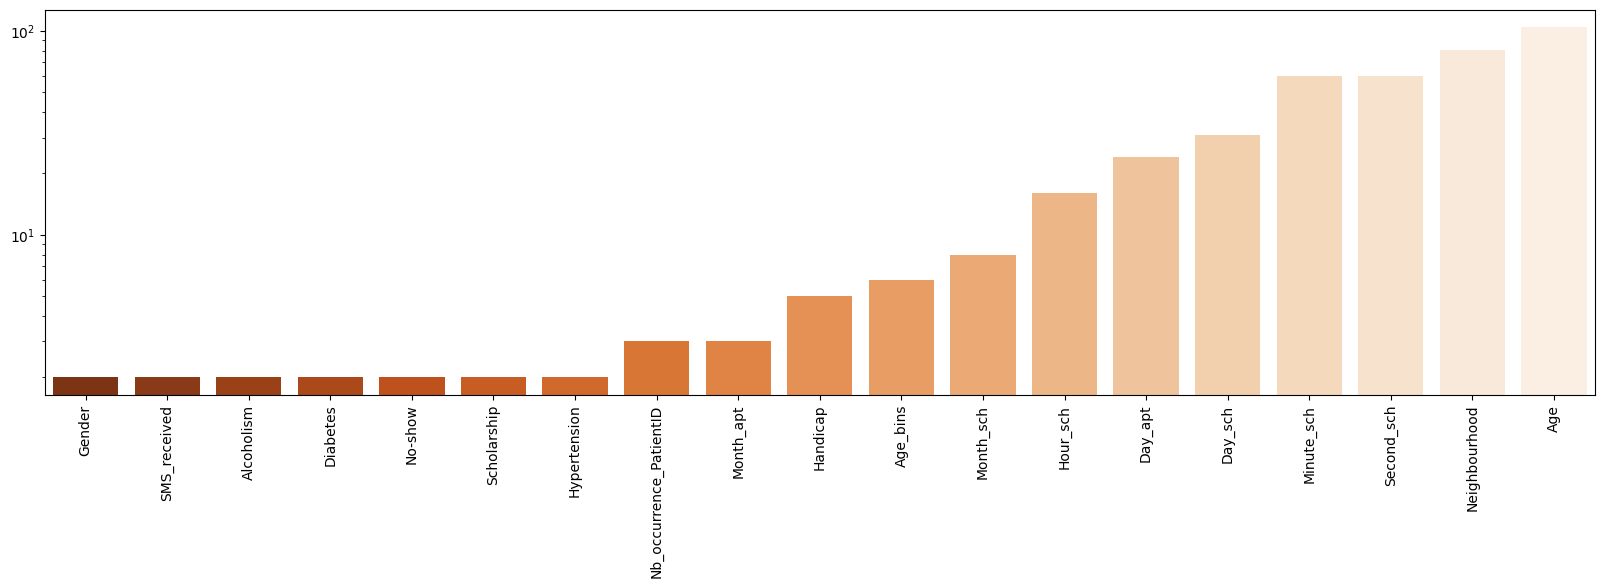

In [39]:
# Label encoding
cat_to_encode = ['Gender', 'Neighbourhood', 'No-show', 'Age_bins']
data = labelencode(data, cat_to_encode)

# Casting categorical to type 'object'
data = num_to_cat(data, max_unique_values=10)

In [40]:
Y = data['No-show']

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(Y)
y = pd.Series(y)
X = data.drop('No-show', axis=1)

# Modelling 

In [41]:
# Holdout training with lazypredict
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.3, random_state=0, stratify=y)
# kpis, _, best_model, _ = train_classifier_lazy(X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test) # takes 2hours very slow because of SVC clf

In [42]:
# StratifiedKfold with RF

In [43]:
# Default parameters
rf_params = {'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [44]:
train_kpis, valid_kpis = run_model(X, y, params=rf_params, n_splits=5, random_state=12)

5it [03:24, 40.85s/it]


In [45]:
valid_kpis

{'valid_auc_mean': 0.5379091267536837,
 'valid_mcc_mean': 0.18853548433805578,
 'valid_auc_fold_0': 0.5390522687590992,
 'valid_mcc_fold_0': 0.19405928713181667,
 'valid_auc_fold_1': 0.5351819074634131,
 'valid_mcc_fold_1': 0.17657358441783305,
 'valid_auc_fold_2': 0.5364518394742873,
 'valid_mcc_fold_2': 0.1814188770619924,
 'valid_auc_fold_3': 0.5387968678983607,
 'valid_mcc_fold_3': 0.19138265784692104,
 'valid_auc_fold_4': 0.5400627501732584,
 'valid_mcc_fold_4': 0.19924301523171567}

# Feature importance

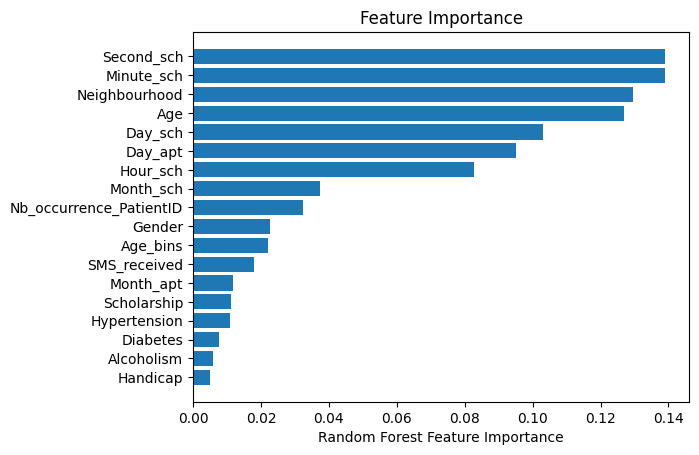

In [46]:
plot_features_importances(X, y)

# Optimize threshold

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.3, random_state=0, stratify=y)

In [48]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier()

In [50]:
# predict proba
lr_probs = model.predict_proba(X_test)
# Keep proba for positive outcome only
lr_probs = lr_probs[:, 1]

In [51]:
thresholds = np.arange(0, 1, 0.01)
aucs, mccs = get_max_metrics(y_test, probs=lr_probs, thresholds=thresholds)

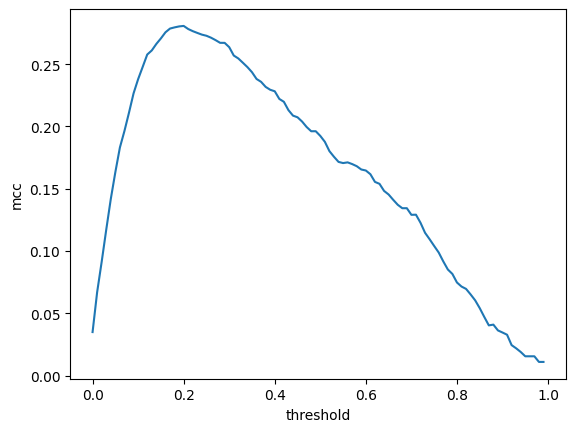

In [52]:
plt.plot(thresholds, mccs.values())
plt.xlabel('threshold')
plt.ylabel('mcc')
plt.show()

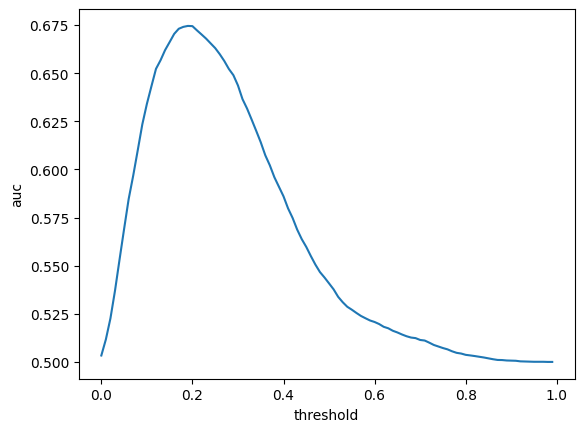

In [54]:
plt.plot(thresholds, aucs.values())
plt.xlabel('threshold')
plt.ylabel('auc')
plt.show()